In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300


def plot_mean_table_with_lines(df, colors=None, title="Accuracy means", ylabel="Accuracy",
                               filename=None, dot_size=80, log2=True, ylim=None):
    """
    Plot a DataFrame with methods as rows and sample sizes as columns:
    - Dots for each mean with black outline
    - Dashed line connecting dots for each method
    - Additional black line y = log2(x)
    """

    methods = df.index.tolist()
    x_positions = [float(c) for c in df.columns]  # convert to float for plotting
    values = df.values

    if colors is None:
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(methods)]

    plt.figure(figsize=(12, 6))

    # Plot each method: dots with black outline + dashed lines
    for m_idx, method in enumerate(methods):
        y_vals = values[m_idx, :]
        plt.plot(
            x_positions, y_vals,
            linestyle='--',
            marker='o',
            markersize=dot_size**0.5 * 2,  # scale marker size
            color=colors[m_idx],
            markeredgecolor='black',       # black outline
            markeredgewidth=1.2,
            label=method
        )

    if log2:
        # Add black line y = log2(x)
        x_line = np.linspace(min(x_positions)-100, max(x_positions)+100, 500)
        y_line = np.log2(x_line)  # log2
        plt.plot(x_line, y_line, color='black', linewidth=3, linestyle="--",
                 label='Theoretical maximum – $\log_{2}(N)$')

    # Axes styling
    plt.ylim(ylim)
    plt.tick_params(axis='both', which='major', labelsize=24)
    plt.xlabel('Number of subjects', fontsize=26)
    plt.ylabel(ylabel, fontsize=26)
    plt.title(title, fontsize=28)
    plt.grid(axis='y', linestyle='--', linewidth=1, alpha=0.7)

    plt.tight_layout()
    plt.legend(fontsize=20, ncol=1)

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# Predicting on visit 5

In [2]:
df = pd.read_csv("./data/multiclass_accuracy_means.csv", index_col=0)
df

,500,1000,1500,2000,2500,3000,3500,4000,4500
IMF,0.79892,0.77756,0.760973,0.75076,0.745568,0.738933,0.73424,0.72920,0.72490
Clinical laboratory,0.77836,0.73938,0.713387,0.69334,0.676272,0.665653,0.65390,0.64684,0.63644
Combined,0.93772,0.92618,0.921040,0.91604,0.914560,0.911893,0.90966,0.90410,0.90230


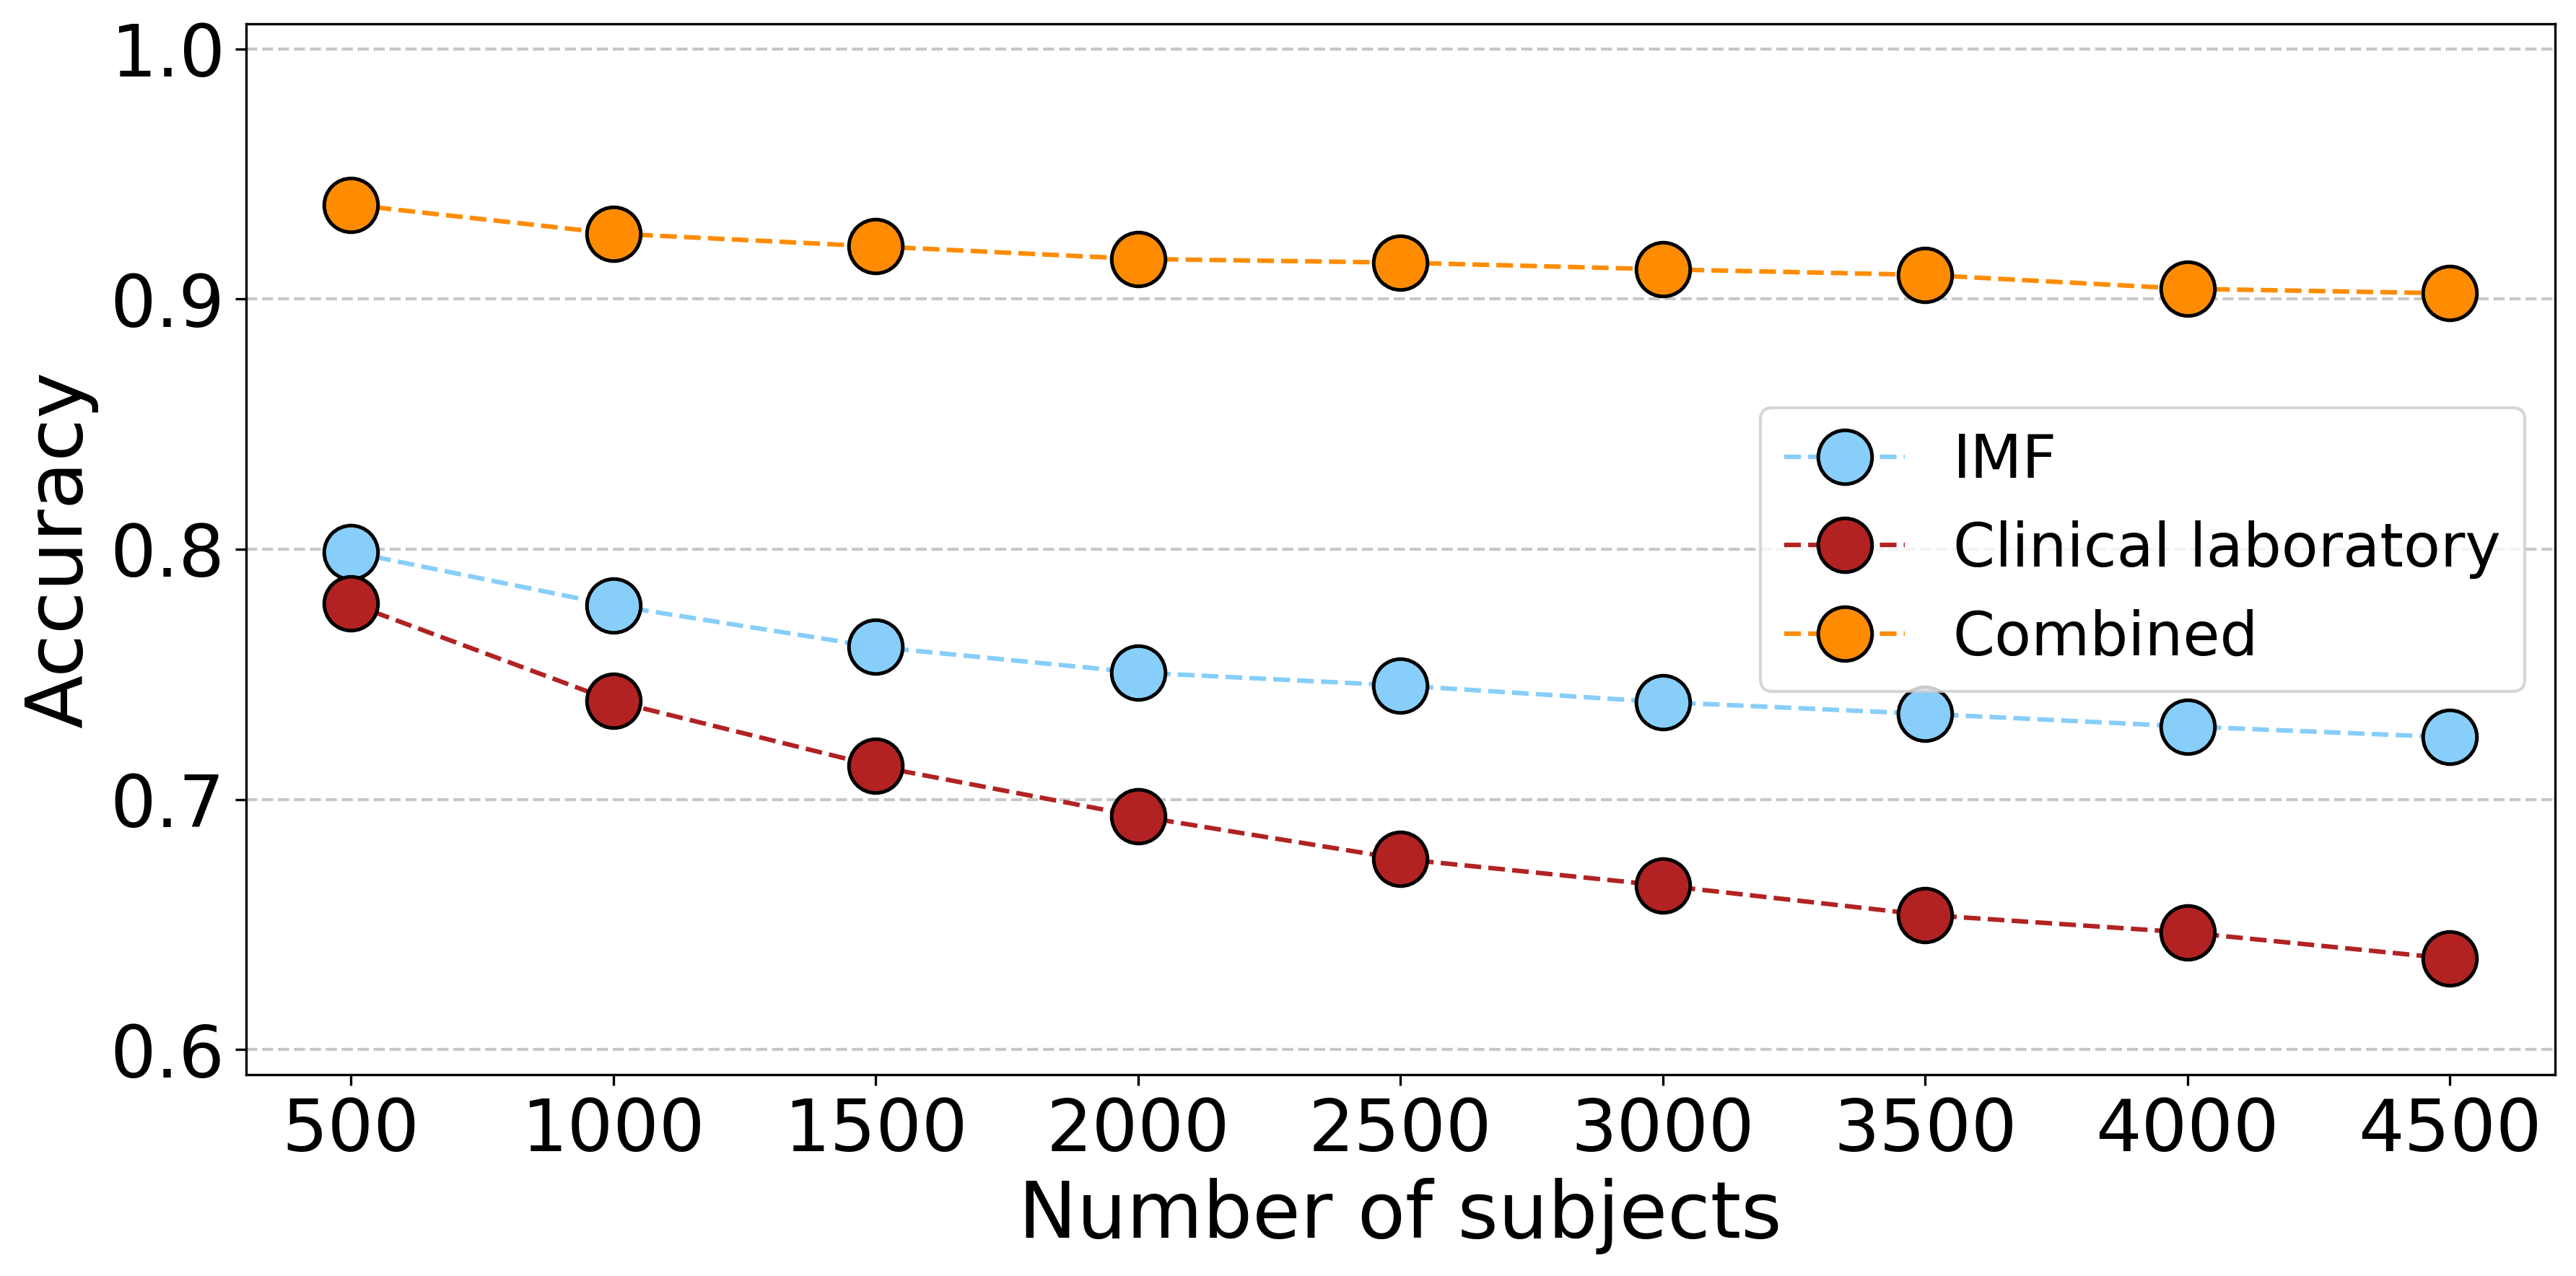

In [3]:
colors = ["lightskyblue", "firebrick", "darkorange"]
plot_mean_table_with_lines(df, colors=colors, title=None, ylabel="Accuracy", 
                           filename="./plots/dotted_accuracy_plot.pdf", log2=False, ylim=(0.59, 1.01))

# Estimating entropy

In [4]:
def estimate_entropy(p, N):
    N = float(N)
    p = float(p)
    return np.log2(p*N)

# Create output table
df_entropy = df.copy()
for N in df_entropy.columns:
    df_entropy[N] = df_entropy[N].apply(lambda p: estimate_entropy(p, N))

i_ = [f"{i} – lower bound" for i in list(df_entropy.index)]
df_entropy.index = i_
df_entropy

,500,1000,1500,2000,2500,3000,3500,4000,4500
IMF – lower bound,8.641907,9.602810,10.156665,10.552208,10.864124,11.114263,11.327463,11.510171,11.671563
Clinical laboratory – lower bound,8.604294,9.530172,10.063503,10.437419,10.723388,10.963590,11.160281,11.337265,11.483806
Combined – lower bound,8.873013,9.855149,10.432083,10.839267,11.158862,11.417684,11.636539,11.820339,11.987388


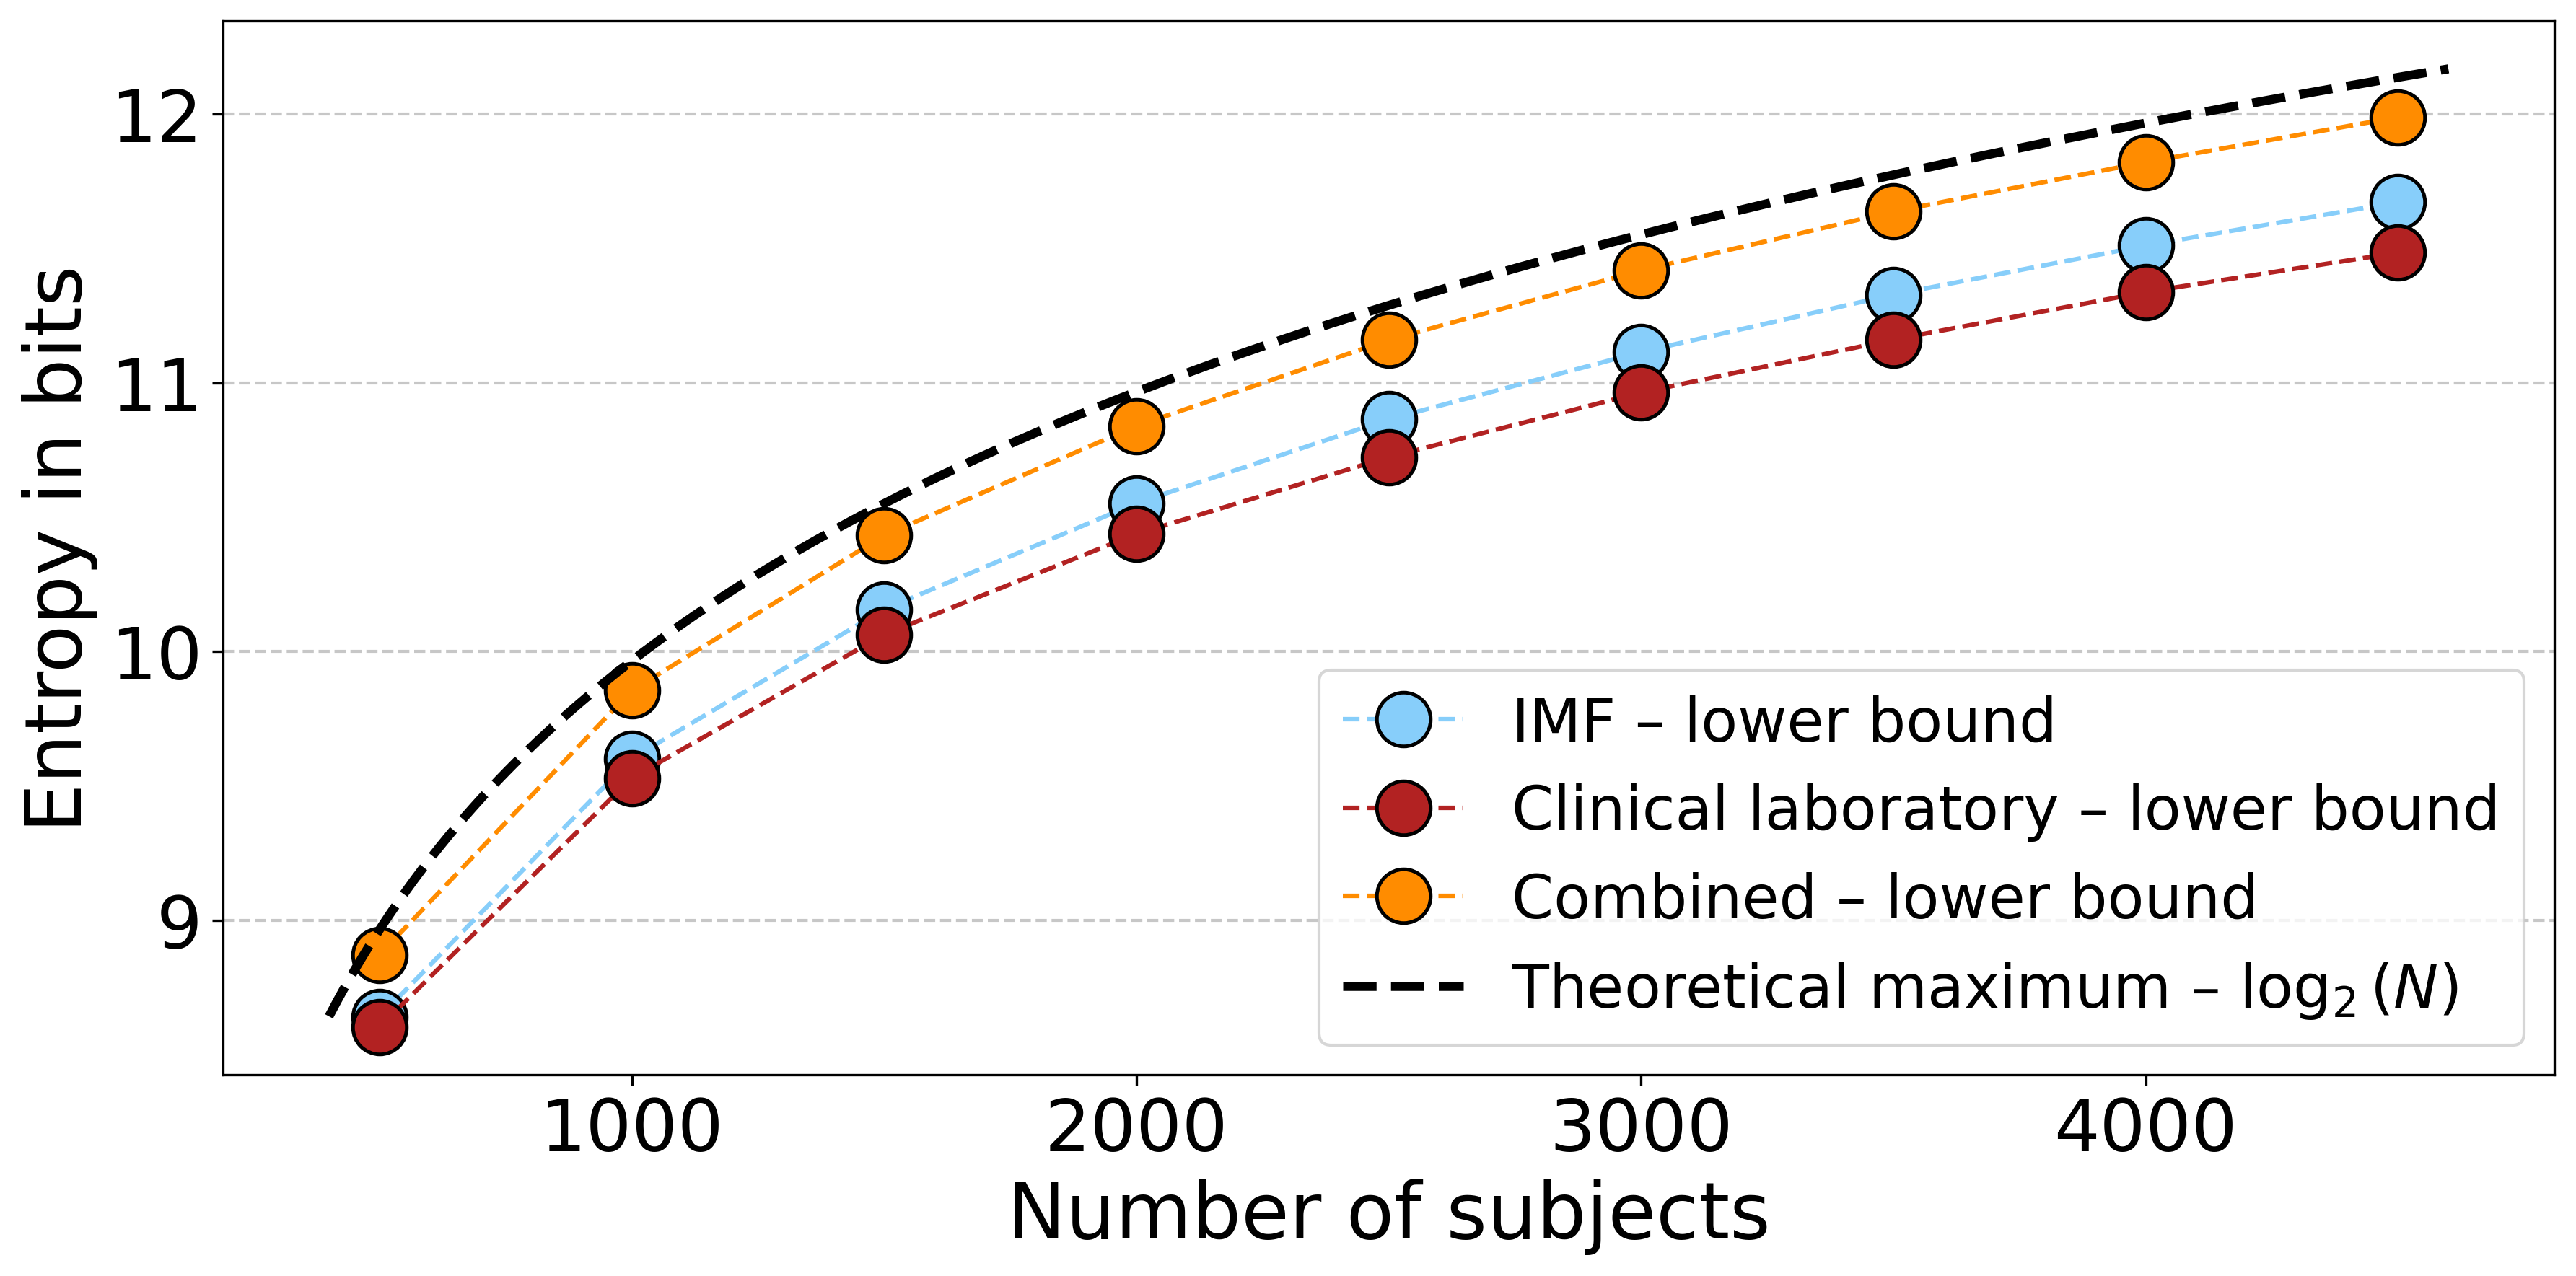

In [5]:
colors = ["lightskyblue", "firebrick", "darkorange"]
plot_mean_table_with_lines(df_entropy, colors=colors, title=None, ylabel="Entropy in bits", 
                           filename="./plots/dotted_entropy_plot_IMF.pdf")

# Box plots for 100 subjects

In [6]:
def draw_box_plots(dfs, columns, labels, colors=None, label_title=None, legend_loc='lower center',
                   title="Multi-class classification - original data", 
                   ylabel="Accuracy", xlabel="Number of classes", w=0.2, filename="", ylim=(0.35, 0.95)):
    
    num_measurements = len(columns)
    num_dfs = len(dfs)  # Number of dataframes (box plots per group)
    
    # Prepare box plot data with spacing
    data = []
    positions = []
    group_spacing = 2  # Space between measurement groups
    box_spacing = 0.3  # Space between boxes within a group
    
    for i, col in enumerate(columns):
        base_pos = i * group_spacing  # Start position for each measurement group
        
        for j in range(num_dfs):
            positions.append(base_pos + (j - (num_dfs-1)/2) * box_spacing)
            data.append(dfs[j][col])
    
    # Create Box Plot
    ax = plt.figure(figsize=(7, 5))
    box = plt.boxplot(data, positions=positions, patch_artist=True, showmeans=False, sym="", widths=w)
    
    if colors is None:
        colors = ["darkblue", "lightskyblue", "firebrick", "coral"]
    
    for i, (patch, median) in enumerate(zip(box['boxes'], box['medians'])):
        patch.set_facecolor(colors[i % num_dfs])  # FIX: Ensure correct color indexing
        median.set_color('black')  # Set median color to black
    
    # Set X-axis labels (one per measurement)
    xtick_positions = [i * group_spacing for i in range(num_measurements)]
    plt.xticks(xtick_positions, columns, rotation=0, ha='center', fontsize=14)
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    # Legend
    plt.legend(handles=[plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(num_dfs)], 
               labels=labels, ncols=1, fontsize=14, loc=legend_loc) 
    
    # Labels and Titles
    plt.ylim(ylim)
    plt.ylabel(ylabel, fontsize=26)
    plt.xlabel(xlabel, fontsize=26)
    plt.title(title, fontsize=30, pad=15)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    if filename != "":
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

In [7]:
bp100 = pd.read_csv("./data/blood_tests_100.csv")
ftir100 = pd.read_csv("./data/ftir_100.csv")
comb100 = pd.read_csv("./data/combined_100.csv")

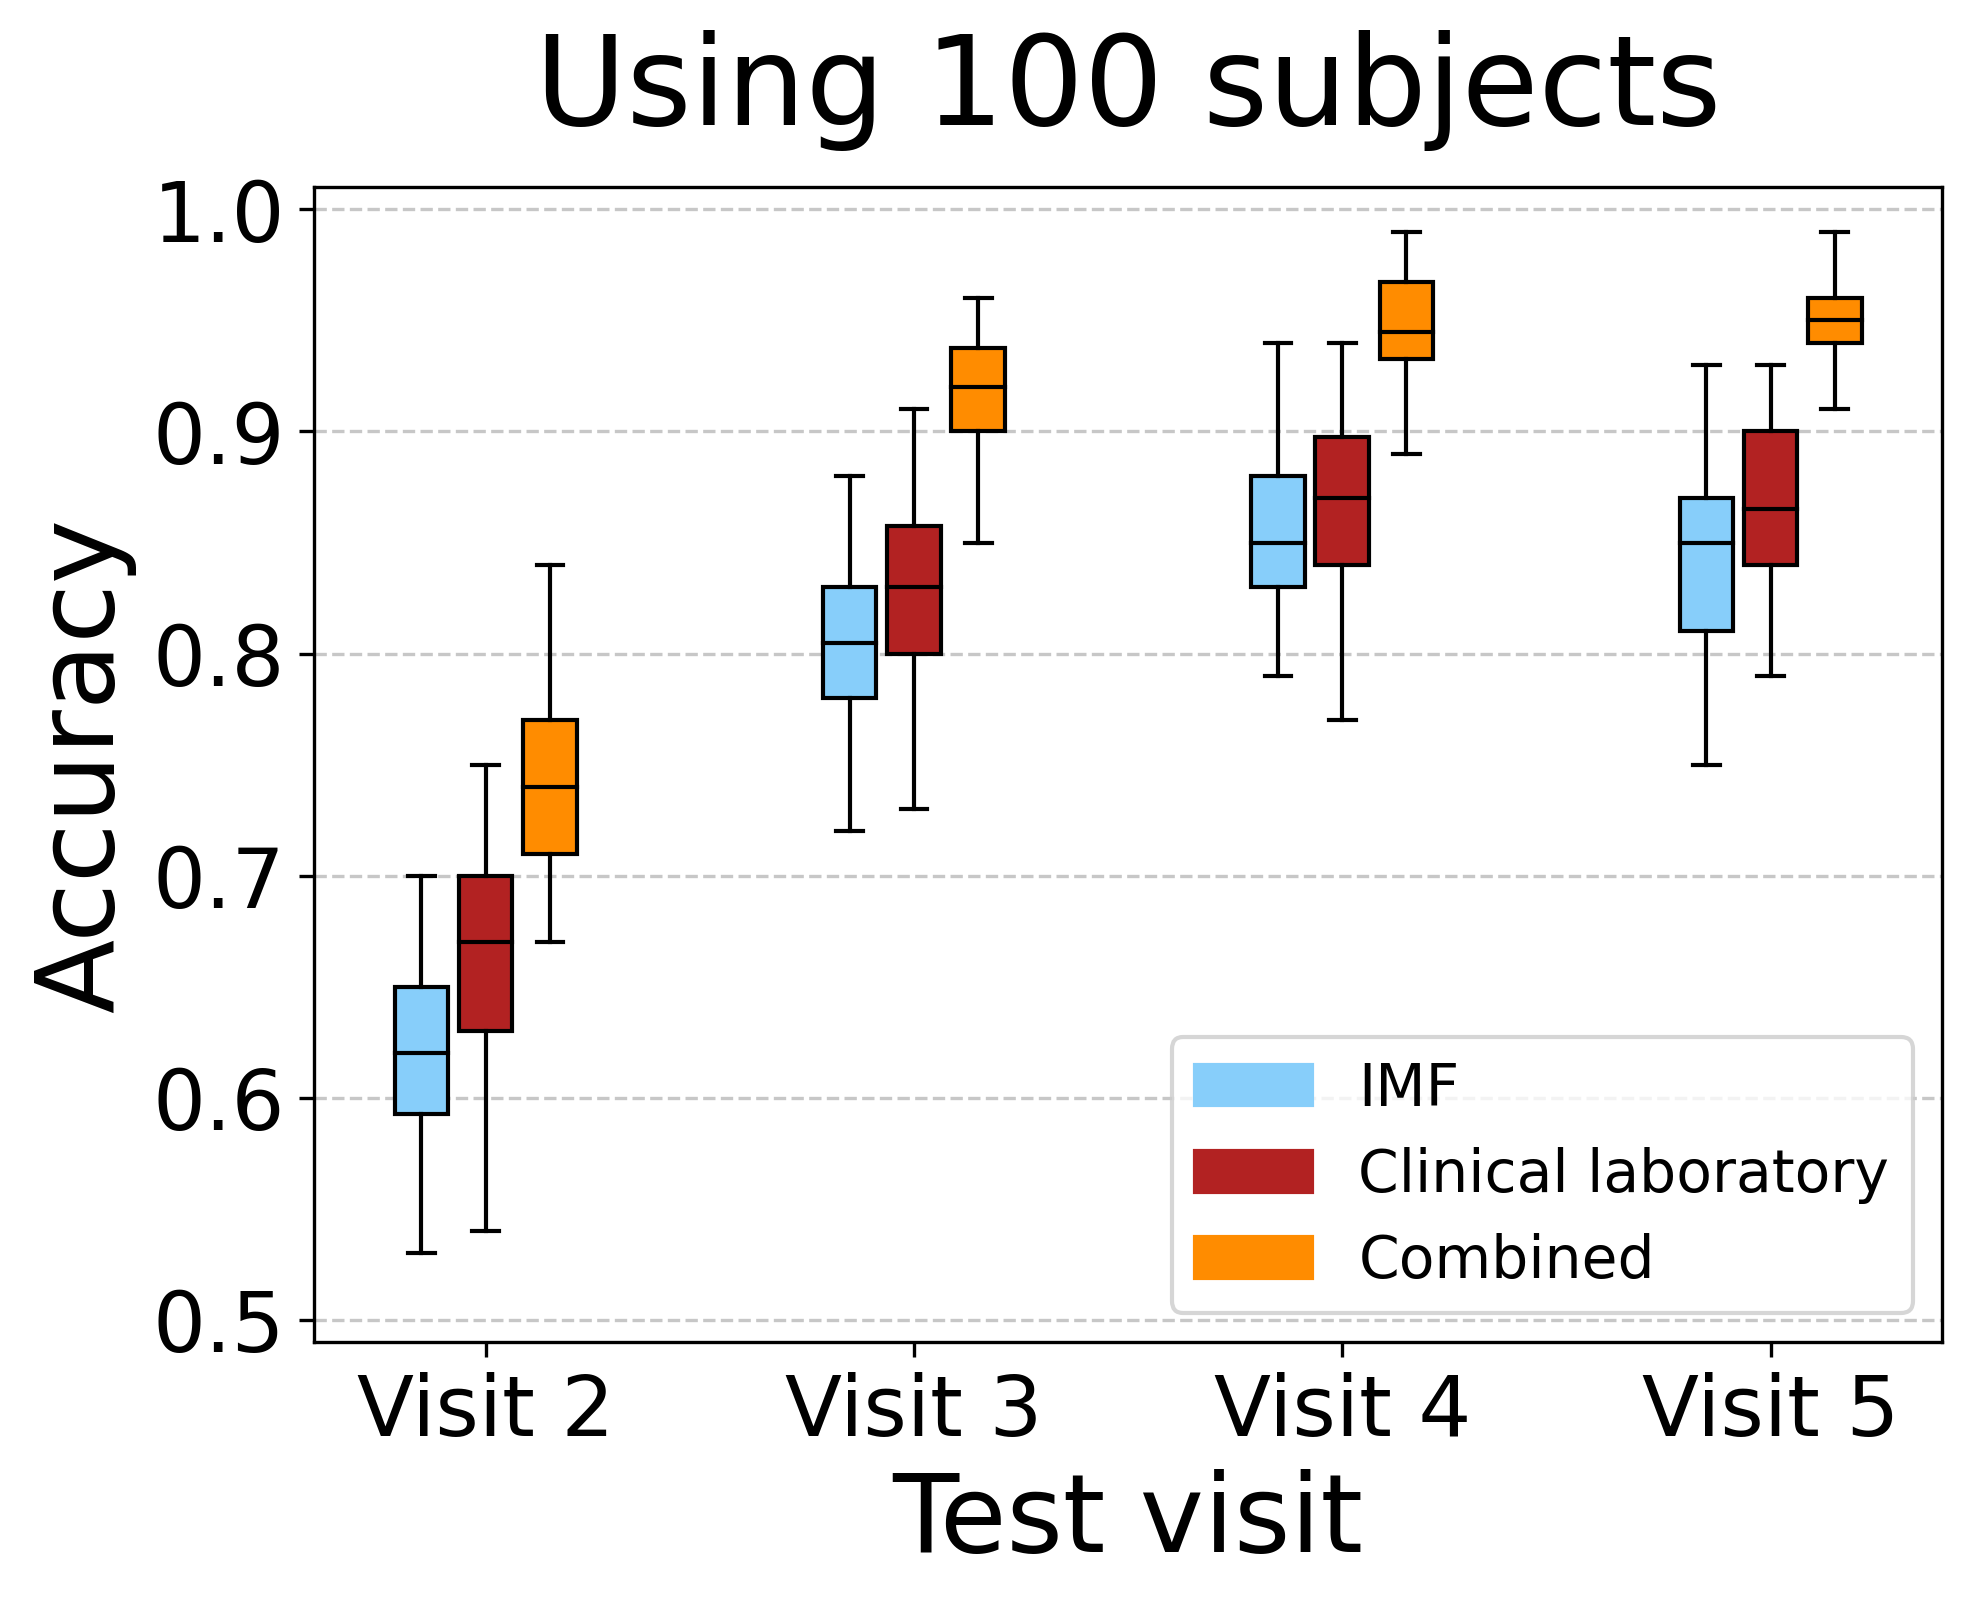

In [8]:
draw_box_plots([ftir100, bp100, comb100], comb100.columns, 
               labels=["IMF", "Clinical laboratory", "Combined"], colors=["lightskyblue", "firebrick", "darkorange"],
               legend_loc='lower right',
               title="Using 100 subjects", 
               ylabel="Accuracy", xlabel="Test visit", w=0.25, 
               filename="./plots/n100_v2-5.pdf", ylim=(0.49, 1.01))